In [97]:
import gtsam
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import time
import random
import math
from __future__ import print_function
from graphviz import Digraph
import graphviz
from gtsam import Rot3, Point3, Pose3
from gtsam.utils import *

In [98]:
import numpy as np


def rotation_matrix_to_euler_angles(R):
    R = np.array(R)

    # Extract individual rotation elements from the rotation matrix
    yaw = np.arctan2(R[1, 0], R[0, 0])
    pitch = np.arctan2(-R[2, 0], np.sqrt(R[2, 1] ** 2 + R[2, 2] ** 2))
    roll = np.arctan2(R[2, 1], R[2, 2])

    return yaw, pitch, roll

In [99]:
print("Pose3", dir(Pose3))
print("Rot3", dir(Rot3))

Pose3 ['Adjoint', 'AdjointMap', 'AdjointTranspose', 'Align', 'Expmap', 'ExpmapDerivative', 'Identity', 'Logmap', 'LogmapDerivative', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', 'adjoint', 'adjointMap', 'adjointMap_', 'adjointTranspose', 'adjoint_', 'between', 'compose', 'deserialize', 'equals', 'expmap', 'inverse', 'localCoordinates', 'logmap', 'matrix', 'print', 'range', 'retract', 'rotation', 'serialize', 'slerp', 'transformFrom', 'transformPoseFrom', 'transformPoseTo', 'transformTo', 'translation', 'wedge', 'x', 'y', 'z']
Rot3 ['AxisAngle', 'ClosestTo', 'Expmap', 'Identity', 'Logmap', 'Pitch', 'Quaternion', 'Rodrigues', 'Roll', 'Rx', 'Ry', 'Rz', 'RzRyRx', 'Yaw', 'Ypr', '__

In [100]:
# Create a new directed graph
# graph_viz = Digraph(comment="Simple Directed Graph")

# # Add nodes to the graph
# graph_viz.node("A")
# graph_viz.node("B")
# graph_viz.node("C")
# graph_viz.node("D")

# # Add edges between nodes
# graph_viz.edge("A", "B")
# graph_viz.edge("B", "C", label="hi")
# # graph_viz.edge("C", "D")
# # graph_viz.edge("D", "A")

# # Render and save the graph in a file
# graph_viz.render("simple_graph", view=False)

In [101]:
custom_colors = [
    "red",
    "green",
    "blue",
    "purple",
    "orange",
    "cyan",
    "magenta",
    "yellow",
    "lime",
    "teal",
]

In [102]:
def plot_arrows_6dof(points_xyz_and_angles, colors=None):
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Extract individual components from the points_xyz_and_angles
    points_xyz_and_angles = np.array(points_xyz_and_angles)
    xyz_coordinates = points_xyz_and_angles[:, :3]  # Extract XYZ coordinates
    x, y, z = xyz_coordinates[:, 0], xyz_coordinates[:, 1], xyz_coordinates[:, 2]

    # Arrow length (you can adjust this based on your needs)
    arrow_length = 30

    for i, point in enumerate(points_xyz_and_angles):
        x_i, y_i, z_i, yaw, pitch, roll = point
        yaw_rad, pitch_rad, roll_rad = (
            np.radians(yaw),
            np.radians(pitch),
            np.radians(roll),
        )

        # Compute the arrow components in the X, Y, and Z directions
        dx = arrow_length * np.cos(pitch_rad) * np.cos(yaw_rad)
        dy = arrow_length * np.cos(pitch_rad) * np.sin(yaw_rad)
        dz = arrow_length * np.sin(pitch_rad)

        color = colors[i] if colors is not None else "b"

        # Plot the arrow with the specified color
        ax.quiver(x_i, y_i, z_i, dx, dy, dz, color=color, arrow_length_ratio=0.2)

    # Set labels for each axis
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Adjust the plot limits (you can adjust this based on your data range)
    min_x = min(x)
    max_x = max(x)
    min_y = min(y)
    max_y = max(y)
    min_z = min(z)
    max_z = max(z)

    ax.set_xlim([min_x - arrow_length, max_x + arrow_length])
    ax.set_ylim([min_y - arrow_length, max_y + arrow_length])
    ax.set_zlim([min_z - arrow_length, max_z + arrow_length])

    plt.show()


# # Example input in the format [[x1, y1, z1, yaw1, pitch1, roll1], [x2, y2, z2, yaw2, pitch2, roll2], ...]
# points_xyz_and_angles = [[100, 100, 100, 30, 45, 60],
#                          [100, 400, 100, 45, 60, 90],
#                          [400, 100, 100, 60, 90, 120],
#                          [400, 400, 100, 90, 120, 150],
#                          [250, 400, 100, 120, 150, 180],[0,0,0,0,0,0]]

# custom_colors = ['red', 'green', 'blue', 'purple', 'orange', 'red']

# # # Call the plot_arrows_6dof function to visualize 6-DOF points as arrows with custom colors
# # plot_arrows_6dof(points_xyz_and_angles, colors=custom_colors)# # Call the plot_arrows_6dof function to visualize 6-DOF points as arrows with custom colors
# plot_arrows_6dof(points_xyz_and_angles, colors=custom_colors)

In [103]:
def plot_points_3dof(xyz_coordinates, colors=None, labels=["X", "Y", "Z"]):
    # Convert xyz_coordinates to numpy array
    xyz_coordinates = np.array(xyz_coordinates)

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # # Set custom colors if provided
    if colors is not None:
        ax.scatter(
            xyz_coordinates[:, 0],
            xyz_coordinates[:, 1],
            xyz_coordinates[:, 2],
            c=colors,
            marker="o",
        )
    else:
        # Plot the points with default color 'b' if custom colors are not provided
        ax.scatter(
            xyz_coordinates[:, 0],
            xyz_coordinates[:, 1],
            xyz_coordinates[:, 2],
            c="b",
            marker="o",
        )

    # Set labels for each axis
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])

    # Show the plot
    plt.show()


# # Example XYZ coordinates and custom colors
# Scene1 = [
#     [100, 100, 100],
#     [100, 400, 100],
#     [400, 100, 100],
#     [400, 400, 100],
#     [250, 400, 100],
#     [0, 0, 0],
# ]


# # # Call the function to visualize the points with custom colors
# plot_points_3dof(Scene1, colors=custom_colors)

[[ 1. -0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
Real Rotation Matrix :  True
[[100, 10, 10], [10, 400, 10], [40, 10, 10], [40, 40, 10], [25, 25, 100]]
[array([10., 10., 10.]), array([10., 40., 10.]), array([40., 10., 10.]), array([40., 40., 10.]), array([ 25.,  25., 100.])]


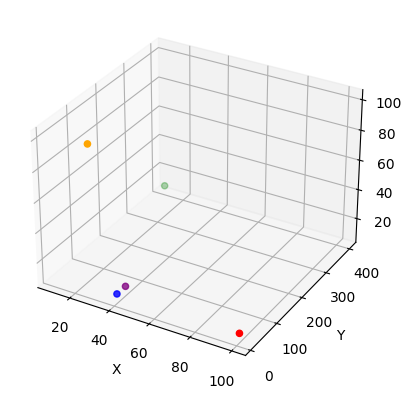

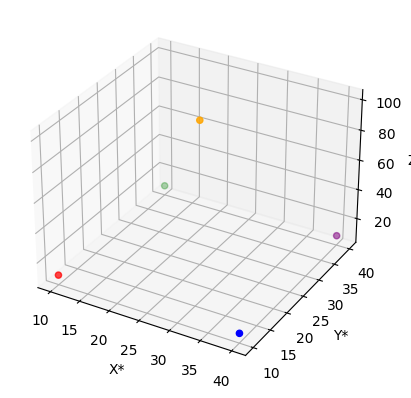

In [104]:
# for Dynamic Static for 3d point
Scene1 = [[100, 10, 10], [10, 400, 10], [40, 10, 10], [40, 40, 10], [25, 25, 100]]
Scene2 = [[10, 10, 10], [10, 40, 10], [40, 10, 10], [40, 40, 10], [25, 25, 100]]

Scene3 = []

angle = 0

R = np.asarray(
    [
        [math.cos(angle * math.pi / 180), -math.sin(angle * math.pi / 180), 0],
        [math.sin(angle * math.pi / 180), math.cos(angle * math.pi / 180), 0],
        [0, 0, 1],
    ]
)

# Identity
R = np.asarray(
    [
        [math.cos(angle * math.pi / 180), -math.sin(angle * math.pi / 180), 0],
        [math.sin(angle * math.pi / 180), math.cos(angle * math.pi / 180), 0],
        [0, 0, 1],
    ]
)

print(R)
print("Real Rotation Matrix : ", np.linalg.det(R) == 1)

for i in range(len(Scene2)):
    S = R @ np.asarray(Scene2[i]).T
    Scene3.append(S)

Scene2 = Scene3

print(Scene1)
print(Scene2)
plot_points_3dof(Scene1, colors=custom_colors[0 : len(Scene1)])
plot_points_3dof(
    Scene2, colors=custom_colors[0 : len(Scene1)], labels=["X*", "Y*", "Z*"]
)

In [105]:
graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

Link1 = gtsam.noiseModel.Diagonal.Sigmas([0.1, 0.1, 0.1])
Link2 = gtsam.noiseModel.Diagonal.Sigmas([0.9, 0.9, 0.9])
Prior = gtsam.noiseModel.Diagonal.Sigmas([0, 0, 0])

graph_vis = Digraph(comment="Simple Directed Graph")
graph_vis = graphviz.Graph()

Poses_Ref = []
Poses_Test = []
index = []

for i in range(len(Scene1)):
    Poses_Ref.append(gtsam.Point3(Scene1[i][0], Scene1[i][1], Scene1[i][2]))

for i in range(len(Scene2)):
    Poses_Test.append(gtsam.Point3(Scene2[i][0], Scene2[i][1], Scene2[i][2]))

graph.add(gtsam.PriorFactorPoint3(i, Poses_Ref[0], Prior))
index.append(0)

for i in range(len(Scene1)):
    for j in range(0, i + 1):
        if i == j:
            continue
        # print(f"{i}, {j}")
        index.append((i, j))
        graph.add(gtsam.BetweenFactorPoint3(i, j, Poses_Ref[j] - Poses_Ref[i], Link1))
    initial.insert(i, Poses_Ref[i])

for i in range(len(Scene2)):
    for j in range(0, i + 1):
        if i == j:
            continue
        # print(f"{i+ len(Scene1)}, {j + len(Scene1)}")
        index.append((i + len(Scene1), j + len(Scene1)))
        graph.add(
            gtsam.BetweenFactorPoint3(
                len(Scene1) + i, len(Scene1) + j, Poses_Test[j] - Poses_Test[i], Link1
            )
        )
    initial.insert(len(Scene1) + i, Poses_Test[i])

for i in range(len(Scene1)):
    graph.add(gtsam.BetweenFactorPoint3(i, i + len(Scene1), [0, 0, 0], Link2))
    index.append((i, i + len(Scene1)))

In [106]:
graph.print("Factor Graph:\n")

Factor Graph:
size: 26

Factor 0: PriorFactor on 4
  prior mean: [
	100;
	10;
	10
]
  noise model: constrained sigmas [0; 0; 0];
  noise model: constrained mu [1000; 1000; 1000];

Factor 1: BetweenFactor(1,0)
  measured: [
	90;
	-390;
	0
]
isotropic dim=3 sigma=0.1

Factor 2: BetweenFactor(2,0)
  measured: [
	60;
	0;
	0
]
isotropic dim=3 sigma=0.1

Factor 3: BetweenFactor(2,1)
  measured: [
	-30;
	390;
	0
]
isotropic dim=3 sigma=0.1

Factor 4: BetweenFactor(3,0)
  measured: [
	60;
	-30;
	0
]
isotropic dim=3 sigma=0.1

Factor 5: BetweenFactor(3,1)
  measured: [
	-30;
	360;
	0
]
isotropic dim=3 sigma=0.1

Factor 6: BetweenFactor(3,2)
  measured: [
	0;
	-30;
	0
]
isotropic dim=3 sigma=0.1

Factor 7: BetweenFactor(4,0)
  measured: [
	75;
	-15;
	-90
]
isotropic dim=3 sigma=0.1

Factor 8: BetweenFactor(4,1)
  measured: [
	-15;
	375;
	-90
]
isotropic dim=3 sigma=0.1

Factor 9: BetweenFactor(4,2)
  measured: [
	15;
	-15;
	-90
]
isotropic dim=3 sigma=0.1

Factor 10: BetweenFactor(4,3)
  measure

In [107]:
# GNC LM Optimizer
LM_params = gtsam.LevenbergMarquardtParams()

gnc_lm_params = gtsam.GncLMParams(LM_params)

inlier = gtsam.KeyVector()
inlier.append(0)
inlier.append(1)
inlier.append(2)
inlier.append(3)
inlier.append(4)
# inlier.append(5)
# inlier.append(6)
gnc_lm_params.setKnownInliers(inlier)

print(gnc_lm_params)

gnc_lm_optimizer = gtsam.GncLMOptimizer(graph, initial, gnc_lm_params)
gnc_lm_optimizer.optimize()

# print("Weights : ", gnc_lm_optimizer.getWeights())
weights = gnc_lm_optimizer.getWeights()

# print(len(weights), len(index))

for i in range(len(weights)):
    print("Edge : ", index[i], " Weigth : ", weights[i])
    print(index[i])
    if i > 0:
        k, l = index[i]
        graph_vis.edge(str(k), str(l), label=str(weights[i]))
graph_vis.render("sample_graph", view=False)

GncParams: 
lossType: Truncated Least-squares
maxIterations: 100
muStep: 1.4
relativeCostTol: 1e-05
weightsTol: 0.0001
verbosity: 0
knownInliers: 0
knownInliers: 1
knownInliers: 2
knownInliers: 3
knownInliers: 4
Base optimizer params: 
relative decrease threshold: 1e-05
absolute decrease threshold: 1e-05
      total error threshold: 0
         maximum iterations: 100
                  verbosity: SILENT
         linear solver type: MULTIFRONTAL CHOLESKY
                   ordering: COLAMD
              lambdaInitial: 1e-05
               lambdaFactor: 10
           lambdaUpperBound: 100000
           lambdaLowerBound: 0
           minModelFidelity: 0.001
            diagonalDamping: 0
                minDiagonal: 1e-06
                maxDiagonal: 1e+32
                verbosityLM: SILENT

Edge :  0  Weigth :  1.0
0
Edge :  (1, 0)  Weigth :  1.0
(1, 0)
Edge :  (2, 0)  Weigth :  1.0
(2, 0)
Edge :  (2, 1)  Weigth :  1.0
(2, 1)
Edge :  (3, 0)  Weigth :  1.0
(3, 0)
Edge :  (3, 1)  Weigth : 

'sample_graph.pdf'

In [108]:
rotation = Rot3.Ypr(0.0, 0.0, 0.78)
point = Point3(1, 0, 0)
a = Pose3(rotation, point)

Scene1 = [
    Pose3(Rot3(1, 0, 0, 0, 1, 0, 0, 0, 1), Point3(10, 10, 10)),
    Pose3(Rot3(1, 0, 0, 0, 1, 0, 0, 0, 1), Point3(10, 40, 10)),
    Pose3(Rot3(), Point3()),
    Pose3(Rot3(), Point3()),
    Pose3(Rot3(), Point3()),
]

# move and rotate
Identity = Pose3(Rot3.Ypr(0, 0, math.pi / 2), Point3(1, 0, 0))
Pose_Transform = Pose3(Rot3(), Point3(1, 0, 0))

print(Scene1[0] * Identity)
print(Identity)

print(Scene1[0].inverse() * Scene1[1])

R: [
	1, 0, 0;
	0, 6.123234e-17, -1;
	0, 1, 6.123234e-17
]
t: 11 10 10

R: [
	1, 0, 0;
	0, 6.123234e-17, -1;
	-0, 1, 6.123234e-17
]
t: 1 0 0

R: [
	1, 0, 0;
	0, 1, 0;
	0, 0, 1
]
t:  0 30  0



In [109]:
# for Dynamic Static for 3d pot

Scene1 = [
    Pose3(Rot3(1, 0, 0, 0, 1, 0, 0, 0, 1), Point3(10, 10, 10)),
    Pose3(Rot3(1, 0, 0, 0, 1, 0, 0, 0, 1), Point3(10, 40, 10)),
    Pose3(Rot3(), Point3(0, 0, 0)),
    Pose3(Rot3(), Point3(0, 0, 0)),
    Pose3(Rot3(), Point3(0, 0, 0)),
]

print(Scene1)
transform = Pose3(Rot3(), Point3(0, 0, 0))
deviation = Pose3(Rot3.Ypr(0, 0, math.radians(20)), Point3(0, 0, 0))

Scene2 = [
    Pose3(Rot3(1, 0, 0, 0, 1, 0, 0, 0, 1), Point3(10, 10, 10)),
    Pose3(Rot3(1, 0, 0, 0, 1, 0, 0, 0, 1), Point3(10, 40, 10)),
    Pose3(Rot3(), Point3(0, 0, 0)),
    Pose3(Rot3(), Point3(0, 0, 0)),
    Pose3(Rot3(), Point3(0, 0, 0)),
]

Scene3 = Scene1

[R: [
	1, 0, 0;
	0, 1, 0;
	0, 0, 1
]
t: 10 10 10
, R: [
	1, 0, 0;
	0, 1, 0;
	0, 0, 1
]
t: 10 40 10
, R: [
	1, 0, 0;
	0, 1, 0;
	0, 0, 1
]
t: 0 0 0
, R: [
	1, 0, 0;
	0, 1, 0;
	0, 0, 1
]
t: 0 0 0
, R: [
	1, 0, 0;
	0, 1, 0;
	0, 0, 1
]
t: 0 0 0
]


In [110]:
def transform_poses(poses, R, t):
    """
    Transforms a list of poses by rotating them around a point and translating them.
    """
    # Convert R and t to gtsam.Pose3
    T = Pose3(
        Rot3(R[0], R[1], R[2], R[3], R[4], R[5], R[6], R[7], R[8]),
        Point3(t[0], t[1], t[2]),
    )

    # Create an empty list to store the transformed poses
    transformed_poses = []

    # Loop through each pose in the list
    for pose in poses:
        # Transform the pose using T
        transformed_pose = T.transform(pose)

        # Add the transformed pose to the list
        transformed_poses.append(transformed_pose)

    return transformed_poses


def transform_poses(poses, R, t):
    """
    Transforms a list of poses by rotating them around a given rotation matrix R and translating them by t.
    """
    # Convert R and t to gtsam.Rot3 and gtsam.Point3
    rot_matrix = gtsam.Rot3(R[0], R[1], R[2], R[3], R[4], R[5], R[6], R[7], R[8])
    translation = gtsam.Point3(t[0], t[1], t[2])

    # Create the transformation as a gtsam.Pose3
    T = gtsam.Pose3(rot_matrix, translation)

    # Create an empty list to store the transformed poses
    transformed_poses = []

    # Loop through each pose in the list
    for pose in poses:
        # Transform the pose using T
        transformed_pose = T.compose(pose)

        # Add the transformed pose to the list
        transformed_poses.append(transformed_pose)

    return transformed_poses


# Example usage
poses = [
    gtsam.Pose3(),
    gtsam.Pose3(gtsam.Rot3.Ypr(0, 0, math.pi / 2), gtsam.Point3(30, 0, 0)),
    gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(0, 20, 0)),
]

print("Poses ", poses)

R = [1, 0, 0, 0, -1, 0, 0, 0, -1]
t = [1, 0, 0]

transform_poses_val = transform_poses(poses, R, t)
print("\ntransform poses", transform_poses_val)

Poses  [R: [
	1, 0, 0;
	0, 1, 0;
	0, 0, 1
]
t: 0 0 0
, R: [
	1, 0, 0;
	0, 6.123234e-17, -1;
	-0, 1, 6.123234e-17
]
t: 30  0  0
, R: [
	1, 0, 0;
	0, 1, 0;
	0, 0, 1
]
t:  0 20  0
]

transform poses [R: [
	1, 0, 0;
	0, -1, 0;
	0, 0, -1
]
t: 1 0 0
, R: [
	1, 0, 0;
	0, -6.123234e-17, 1;
	0, -1, -6.123234e-17
]
t: 31  0  0
, R: [
	1, 0, 0;
	0, -1, 0;
	0, 0, -1
]
t:   1 -20   0
]


In [117]:
transfom_mat = []

for pose in transform_poses_val:
    R_mat = [
        [
            pose.rotation().matrix()[0][0],
            pose.rotation().matrix()[0][1],
            pose.rotation().matrix()[0][2],
        ],
        [
            pose.rotation().matrix()[1][0],
            pose.rotation().matrix()[1][1],
            pose.rotation().matrix()[1][2],
        ],
        [
            pose.rotation().matrix()[2][0],
            pose.rotation().matrix()[2][1],
            pose.rotation().matrix()[2][2],
        ],
    ]
    T_mat = [pose.translation()[0], pose.translation()[1], pose.translation()[2]]
    y, p, r = rotation_matrix_to_euler_angles(R_mat)
    transfom_mat.append(
        [pose.translation()[0], pose.translation()[1], pose.translation()[2], y, p, r]
    )

transform_mat_original = []
for pose in poses:
    R_mat = [
        [
            pose.rotation().matrix()[0][0],
            pose.rotation().matrix()[0][1],
            pose.rotation().matrix()[0][2],
        ],
        [
            pose.rotation().matrix()[1][0],
            pose.rotation().matrix()[1][1],
            pose.rotation().matrix()[1][2],
        ],
        [
            pose.rotation().matrix()[2][0],
            pose.rotation().matrix()[2][1],
            pose.rotation().matrix()[2][2],
        ],
    ]
    T_mat = [pose.translation()[0], pose.translation()[1], pose.translation()[2]]
    y, p, r = rotation_matrix_to_euler_angles(R_mat)
    transform_mat_original.append(
        [pose.translation()[0], pose.translation()[1], pose.translation()[2], y, p, r]
    )

print(transfom_mat)

[[1.0, 0.0, 0.0, 0.0, -0.0, 3.141592653589793], [31.0, 0.0, 0.0, 0.0, -0.0, -1.5707963267948968], [1.0, -20.0, 0.0, 0.0, -0.0, 3.141592653589793]]


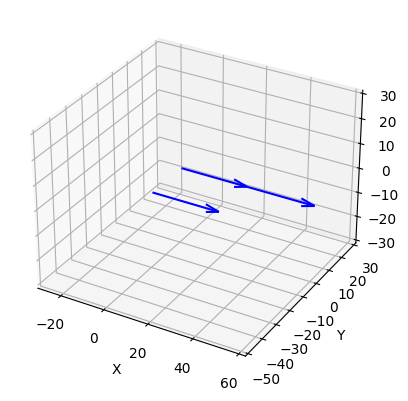

In [118]:

plot_arrows_6dof(transfom_mat)

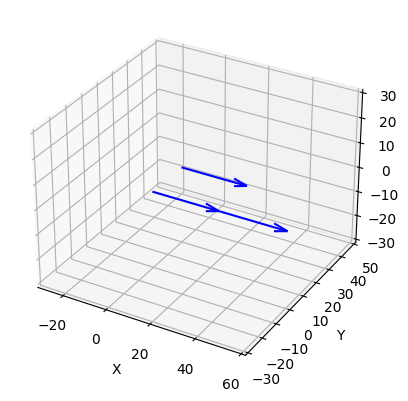

In [119]:

plot_arrows_6dof(transform_mat_original)

In [114]:
print(poses[0].translation())
print(poses[0].rotation().matrix())

[0. 0. 0.]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [115]:
"""Main runner."""
# Read graph from file
g2oFile = gtsam.findExampleDataFile("pose3example.txt")

is3D = True
graph, initial = gtsam.readG2o(g2oFile, is3D)

# Add prior on the first key. TODO: assumes first key ios z
priorModel = gtsam.noiseModel.Diagonal.Variances(
    np.array([1e-6, 1e-6, 1e-6, 1e-4, 1e-4, 1e-4])
)
firstKey = initial.keys()[0]
graph.add(gtsam.PriorFactorPose3(0, gtsam.Pose3(), priorModel))

# Initializing Pose3 - chordal relaxation
initialization = gtsam.InitializePose3.initialize(graph)

print(initialization)

Values with 5 values:
Value 0: (gtsam::Pose3)
R: [
	1, 1.28762872e-12, -1.6941556e-12;
	-1.28771198e-12, 1, -2.41021582e-12;
	1.69443316e-12, 2.41039623e-12, 1
]
t:  6.65921741e-12 -1.36469685e-11   6.4232761e-12

Value 1: (gtsam::Pose3)
R: [
	0.744448037, 0.587991884, 0.316326832;
	-0.623605499, 0.781599939, 0.0147552099;
	-0.238565089, -0.208247639, 0.948535513
]
t: 0.215737144 -0.45589787 0.226220058

Value 2: (gtsam::Pose3)
R: [
	-0.661972805, 0.201225657, -0.722011247;
	0.461953509, -0.64904749, -0.604430568;
	-0.590246526, -0.733652227, 0.336694889
]
t:   0.75159972 -0.319500834  0.345609123

Value 3: (gtsam::Pose3)
R: [
	-0.91634833, 0.220249724, 0.334358785;
	0.0853314286, -0.708480438, 0.700552651;
	0.391183187, 0.670481564, 0.630420643
]
t:  0.0327382821 -0.0185502813  -0.358899684

Value 4: (gtsam::Pose3)
R: [
	-0.265828503, -0.635247728, -0.725117598;
	0.961634279, -0.227624953, -0.153122152;
	-0.0677843605, -0.738002171, 0.671385192
]
t:  -0.447671326 -0.0993000041  -0.344

In [116]:
g = gtsam.NonlinearFactorGraph()
gtsam.Symbol("x", 0)

x0